# Predicting logP with Graph Neural Networks using Pytorch Geometric
In this notebook, we will build a graph neural network with Pytorch Geometric (https://pytorch-geometric.readthedocs.io/en/latest/index.html) that predicts the logP value (octanol-water partition coefficient) of molecules. You can find a previous attempt that uses the Spektral library here: https://github.com/cstckr/graph_neural_network_for_logP_prediction/blob/main/graph_neural_network_logP_prediction.ipynb. This notebook was not optimized to achieve similiar/better results compared to the Spektral implementation but is only intented to serve as template how to train a GNN with Pytorch Geometric.

In the Spektral framework it is not trivial to inject additional features (that are not node or edge features) into the GNN. This is unfortunate as GNNs are known to struggle with learning long-range information and seeing "global features" of a graph. Therefore, in this notebook it is demonstrated how easy it is to do so in the Pytorch Geometric framework by feeding the molecular weight of each molecule into the GNN (it is not checked here if this is really an useful thing to do here).

First, we will load the used libraries:

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
from torch.nn import Linear, Sequential, ReLU
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiplicativeLR
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, NNConv, BatchNorm
from torch_geometric.nn.aggr import SoftmaxAggregation
from torchmetrics import MeanSquaredError
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import random
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

seed = 11
random.seed(seed)
np.random.seed(seed)

Now we will load the dataset. The dataset originates from following publication:
- Ulrich, Goss & Ebert, Exploring the octanol–water partition coefficient dataset using deep learning techniques and data augmentation. *Communications Chemistry* **2021**, *4*, 90. www.doi.org/10.1038/s42004-021-00528-9

It can be found via following link: www.github.com/nadinulrich/log_P_prediction/blob/main/Dataset_and_Predictions.xlsx

In the reduced version of the file used here, the dataset contains SMILES strings, logP labels and the unique CAS identifiers.  In the cell below, we load the data set, split it into train, validation, and test set, and scale features:

In [2]:
df = pd.read_csv("dataset.csv")
df["mol"] = df.SMILES.apply(Chem.MolFromSmiles)
df["mw"] = df.mol.apply(Descriptors.MolWt)

unique_CAS = df.CAS.unique()

rs1 = ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train, test in rs1.split(unique_CAS):
    train_validation_CAS = unique_CAS[train]
    test_CAS = unique_CAS[test]

rs2 = ShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
for train, validation in rs2.split(train_validation_CAS):
    validation_CAS = train_validation_CAS[validation]
    train_CAS = train_validation_CAS[train]

df_train = df[df.CAS.isin(train_CAS)].reset_index(drop=True)
df_validation = df[df.CAS.isin(validation_CAS)].reset_index(drop=True)
df_test = df[df.CAS.isin(test_CAS)].reset_index(drop=True)

df_train_scaled = df_train.copy()
df_validation_scaled = df_validation.copy()
df_test_scaled = df_test.copy()

scaler_logP = MinMaxScaler()
scaler_logP.fit(df_train.logP.to_numpy().reshape(-1, 1))
df_train_scaled.logP = (scaler_logP.transform(
    df_train.logP.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]
df_validation_scaled.logP = (scaler_logP.transform(
    df_validation.logP.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]
df_test_scaled.logP = (scaler_logP.transform(
    df_test.logP.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]


scaler_mw = MinMaxScaler()
scaler_mw.fit(df_train.mw.to_numpy().reshape(-1, 1))
df_train_scaled.mw = (scaler_mw.transform(
    df_train.mw.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]
df_validation_scaled.mw = (scaler_mw.transform(
    df_validation.mw.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]
df_test_scaled.mw = (scaler_mw.transform(
    df_test.mw.to_numpy().reshape(-1, 1))).reshape(1, -1)[0]

Next, we extract graph features of the molecules:

In [3]:
bond_types = []
for mol in df.mol:
    bonds = mol.GetBonds()
    for bond in bonds:
        bond_type = str(bond.GetBondType())
        if bond_type not in bond_types:
            bond_types.append(bond_type)

atom_types = []
for mol in df.mol:
    atoms = mol.GetAtoms()
    for atom in atoms:
        atom_type = str(atom.GetSymbol())
        if atom_type not in atom_types:
            atom_types.append(atom_type)
            

class Featurizer:
    def __init__(self, atom_types, bond_types):
        self.atom_types = atom_types
        self.bond_types = bond_types
        self.n_edge_features = len(bond_types)
        self.n_node_features = len(atom_types)

    def get_data(self, mols, mw, y, training=True, split=2/3):
        data_list = []
        for idx, mol in enumerate(mols):
            edge_idx, n_nodes, n_edges = self.get_edge_idx(mol)
            node_attr = self.get_node_attr(mol, n_nodes)
            edge_attr = self.get_edge_attr(mol, edge_idx, n_edges)
            mw_attr = torch.as_tensor(
                mw[idx].reshape(-1, 1)).type(torch.float32)
            y_attr = torch.as_tensor(
                y[idx].reshape(-1, 1)).type(torch.float32)

            data = Data(
                edge_index=edge_idx, x=node_attr, edge_attr=edge_attr,
                y=y_attr, mw_attr=mw_attr)
            data_list.append(data)
        return data_list

    def get_edge_idx(self, mol):
        adj = coo_matrix(Chem.GetAdjacencyMatrix(mol))
        edge_idx = torch.stack([torch.from_numpy(adj.row).to(torch.long),
                                torch.from_numpy(adj.col).to(torch.long)],
                               dim=0)
        n_nodes = adj.shape[0]
        n_edges = np.sum(adj)
        return edge_idx, n_nodes, n_edges

    def get_node_attr(self, mol, n_nodes):
        node_attr = np.zeros(
            shape=(n_nodes, self.n_node_features), dtype=float)
        for count, atom in enumerate(mol.GetAtoms()):
            atom_type = str(atom.GetSymbol())
            if atom_type in self.atom_types:
                idx = self.atom_types.index(atom_type)
                node_attr[count, idx] = 1
        node_attr = torch.from_numpy(node_attr).type(torch.float32)
        return node_attr

    def get_edge_attr(self, mol, edge_idx, n_edges):
        edge_attr = np.zeros(shape=(n_edges, self.n_edge_features), dtype=int)
        for count, (idx1, idx2) in enumerate(zip(edge_idx[0], edge_idx[1])):
            bond_type = str((mol).GetBondBetweenAtoms(
                int(idx1), int(idx2)).GetBondType())
            if bond_type in self.bond_types:
                idx3 = self.bond_types.index(bond_type)
                edge_attr[count, idx3] = 1
        edge_attr = torch.from_numpy(edge_attr).type(torch.float32)
        return edge_attr


featurizer = Featurizer(
    atom_types=atom_types, bond_types=bond_types)
train_data = featurizer.get_data(
    df_train_scaled.mol, df_train_scaled.mw, df_train_scaled.logP)
validation_data = featurizer.get_data(
    df_validation_scaled.mol, df_validation_scaled.mw, 
    df_validation_scaled.logP)
test_data = featurizer.get_data(
    df_test_scaled.mol, df_test_scaled.mw, df_test_scaled.logP)

And then create the DataLoaders:

In [4]:
batch_size = 64

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Now, we define our GNN architecture:

In [5]:
class GCN(LightningModule):
    def __init__(self, hidden_channels, num_node_features, 
                 num_edge_features, num_classes, seed, batch_size):
        super(GCN, self).__init__()
        self.save_hyperparameters()
        torch.manual_seed(seed)

        self.bn1 = BatchNorm(num_node_features)
        self.conv1 = NNConv(
            num_node_features, hidden_channels, nn=self.create_nn(
                [num_edge_features, num_edge_features*4,
                 (hidden_channels * num_node_features)]))

        self.bn2 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)    
        
        self.bn3 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)            

        self.agg1 = SoftmaxAggregation()

        self.lin1 = Linear((hidden_channels)+1, hidden_channels) # +1 because torch.cat step with mw_attr
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, num_classes)
        self.mse = MeanSquaredError()
        self.batch_size = batch_size

    def forward(self, x, edge_index, edge_attr, batch, mw_attr):
        x = self.bn1(x)
        x = x.relu()
        x = self.conv1(x, edge_index, edge_attr)

        x = self.bn2(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        x = self.bn3(x)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = self.agg1(x, batch)

        x = torch.cat((x, mw_attr), dim=1)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        return x

    def training_step(self, batch, batch_idx):
        y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                              batch.batch, batch.mw_attr)
        loss = self.mse(y_pred, batch.y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, 
                 batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                              batch.batch, batch.mw_attr)
        loss = self.mse(y_pred, batch.y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, 
                 batch_size=self.batch_size)
        return loss

    def predict_step(self, batch, batch_idx):
        y_pred = self.forward(batch.x, batch.edge_index, batch.edge_attr, 
                              batch.batch, batch.mw_attr)
        return y_pred
    
    def configure_optimizers(self):
        self.opt = torch.optim.Adam(self.parameters(), lr = 3e-4)
        self.train_scheduler = {
            "scheduler": MultiplicativeLR(
                optimizer=self.opt, lr_lambda=lambda epoch: 0.985, 
                verbose=False),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"}
        return [self.opt], [self.train_scheduler]

    def create_nn(self, kernel_network):
        modules = []
        for i in range(len(kernel_network) - 1):
            modules.append(Linear(kernel_network[i], kernel_network[i+1]))
            modules.append(ReLU())
        return Sequential(*modules)


hyperpars = {"hidden_channels": 128, "num_node_features": len(atom_types),
             "num_edge_features": len(bond_types), "num_classes": 1, 
             "seed": seed, "batch_size": batch_size}

gnn1 = GCN(**hyperpars)

print(f"""Number of trainable parameter in the network: {torch.nn.utils.parameters_to_vector(gnn1.parameters()).numel()}""")

Number of trainable parameter in the network: 90085


Training:

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/gnn

   | Name  | Type               | Params
----------------------------------------------
0  | bn1   | BatchNorm          | 20    
1  | conv1 | NNConv             | 23.2 K
2  | bn2   | BatchNorm          | 256   
3  | conv2 | GCNConv            | 16.5 K
4  | bn3   | BatchNorm          | 256   
5  | conv3 | GCNConv            | 16.5 K
6  | agg1  | SoftmaxAggregation | 0     
7  | lin1  | Linear             | 16.6 K
8  | lin2  | Linear             | 16.5 K
9  | lin3  | Linear             | 129   
10 | mse   | MeanSquaredError   | 0     
----------------------------------------------
90.1 K    Trainable params
0         Non-trainable params
90.1 K    Total params
0.360     Total estimated model params size (MB)


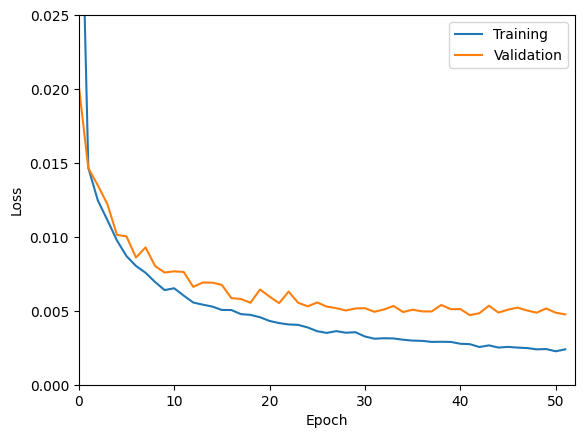

In [6]:
cb1 = ModelCheckpoint(monitor='val_loss', mode='min')
cb2 = EarlyStopping(monitor="val_loss", mode="min", patience=10)

num_epochs = 100
val_check_interval = len(train_loader)
logger = CSVLogger(save_dir="logs/", name="gnn", flush_logs_every_n_steps=1)

trainer = Trainer(max_epochs=num_epochs,
                  val_check_interval=val_check_interval, 
                  callbacks=[cb1, cb2],
                  logger=logger,
                  enable_progress_bar=False)

trainer.fit(gnn1, train_loader, validation_loader)

history = pd.read_csv(Path(trainer.logger.log_dir + "/metrics.csv"))
history_train = history.dropna(subset=["train_loss"])
history_val = history.dropna(subset=["val_loss"])

fig, ax = plt.subplots()
ax.plot(history_train.epoch, history_train.train_loss, label="Training")
ax.plot(history_val.epoch, history_val.val_loss, label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_xlim(0, len(history_train))
ax.set_ylim(0, 0.025)
ax.legend()
plt.show()

And finally, let's predict on the holdout test data set:

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.33it/s]


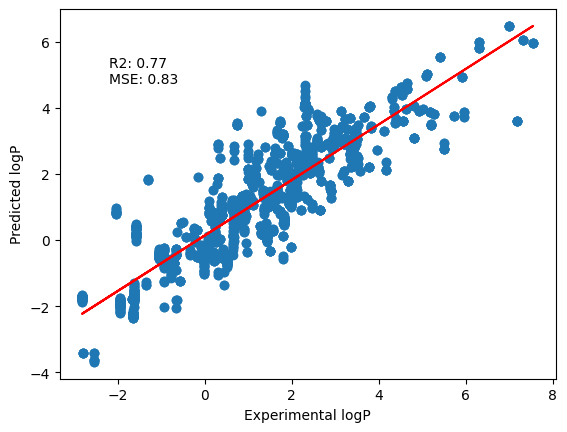

In [7]:
checkpoint_file = trainer.checkpoint_callback.best_model_path
model = GCN.load_from_checkpoint(checkpoint_file, **hyperpars)
model.eval()

trainer = Trainer()
y_test_pred = torch.cat(trainer.predict(model, dataloaders=test_loader))
y_test_pred = scaler_logP.inverse_transform(y_test_pred.numpy()).reshape(-1, 1)
y_test_pred = y_test_pred.flatten()

fig, ax = plt.subplots()
ax.scatter(df_test.logP, y_test_pred)
m, b = np.polyfit(df_test.logP, y_test_pred, 1)
ax.plot(df_test.logP, (m * df_test.logP + b), color="red")
ax.set_xlabel("Experimental logP")
ax.set_ylabel("Predicted logP")

ax.text(0.1, 0.8, f"""R2: {round(r2_score(df_test.logP, y_test_pred), 2)} 
MSE: {round(mean_squared_error(df_test.logP, y_test_pred), 2)}""", 
transform=ax.transAxes)
plt.show()